# CRISP DM Framework for data mining applied to bosch cnc machining dataset
### 1. Business understanding
#### Determine the business objectives
##### Determine the background, business objectives and business success criteria.
Background: Bosch Industrial machines has mounted a vibration sensor on the back spindle of a CNC 4 axis machine. Three different machines have been monitored for X Y and Z vibrational response in the time domain. During these observations 13 different machining operations had been completed numerous times over the span of multiple months on all three machines. On some occaisions the factors had contributed to the failure of the process as labelled by operators after the process. The objective is to create a model that can analyze vibrational response of the machine for given window sizes (time periods) and determine whether to continue the operation or hault immediately for operator intervention. The successful implementation of this model should achieve a %95 success rate in finding the labelled errors in the data set for the test data set.

#### Asses the situation
##### Inventory of resources
The resources available for this project is the "CNC machining data set" provided by Bosch. The data set presents raw data from the vibration monitor for the XYZ directions.
Secondary resources include a published article on initial work for the data set and supplementary information found at the following link: https://www.sciencedirect.com/science/article/pii/S2212827122002384

Due data: End module 24

Comprehensibility: The results should be given as the best model between multiple classification models. For each type of classifier used, the best model must be shown using a suitable metric such as ROC curve or confusion matrix. Further some exploration must be done on the variations between the operations and machines to determine whether there are any unique instances or if an all encompassing model could be used for all operations and machines.

##### Terminology.
CNC - computer numerical control

FFT - fast fourier transform (takes cyclical data and returns the frequency response info)

spectral centroid - Measure of the central frequency of a signal (average frequency)

spectral flux - measure of rate of change in of the power spectrum

peak frequencies - from fft, represents the frequqncy components with the largest magnitude in a signal.

bandwith - represents the range of frequencies in a signal that contains the energy

power threshold - represents how much of the signal energy is used in the bandwidth calculation (0.5 meaning %50 of the total power).

##### Costs and benefits.

Not applicable

#### Project plan
1. Develop initial metrics to be used for the features
    a. Determine whether TSfresh is useful for creation of features for model. 
    b. use FFT to produce descriptive metrics of the requency response in XYZ
        -spectral centroid
        -spectral flux
        -peak frequencies
        -bandwidths
2. Produce initial model (random forest or standard decision tree) and use a gridsearch to find the optimal hyperparameters for the implementation of the model.
3. Report feature importance in model for the best model from gridsearch.
4. Fit final model and save to file.
   

In [1]:
%%capture
!pip install matplotlib
!pip install tsfresh
!pip install tqdm
!pip install imbalanced-learn

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings

from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, confusion_matrix

from mpl_toolkits.mplot3d import Axes3D

import os
from utils import data_loader_utils

from tqdm import tqdm
import time

from imblearn.over_sampling import RandomOverSampler

# Data Understanding
This section loads the data from the various files required. A brief summary of the data is given as well as checking of the data quality.
### Code to extract data from files:
This section of code was provided by the author of the data set to extract the data and write it into an X and y data sets as lists of lists for.

In [3]:
machines = ["M01","M02","M03"]
process_names = ["OP00","OP01","OP02","OP03","OP04","OP05","OP06","OP07","OP08","OP09","OP10","OP11","OP12","OP13","OP14"]
labels = ["good","bad"]
path_to_dataset = "./data/"

In [4]:
%%capture
X_data = []
y_data = []
for process_name in process_names:
    for machine in machines:
        for label in labels:
            data_path = os.path.join(path_to_dataset, machine, process_name, label)
            data_list, data_label = data_loader_utils.load_tool_research_data(data_path, label=label)
            #concatenating
            X_data.extend(data_list)
            y_data.extend(data_label)

# Displaying the initial signal data.
This section of code was provided by the auther of the data to display the signal of a specific operation done by the CNC machines.


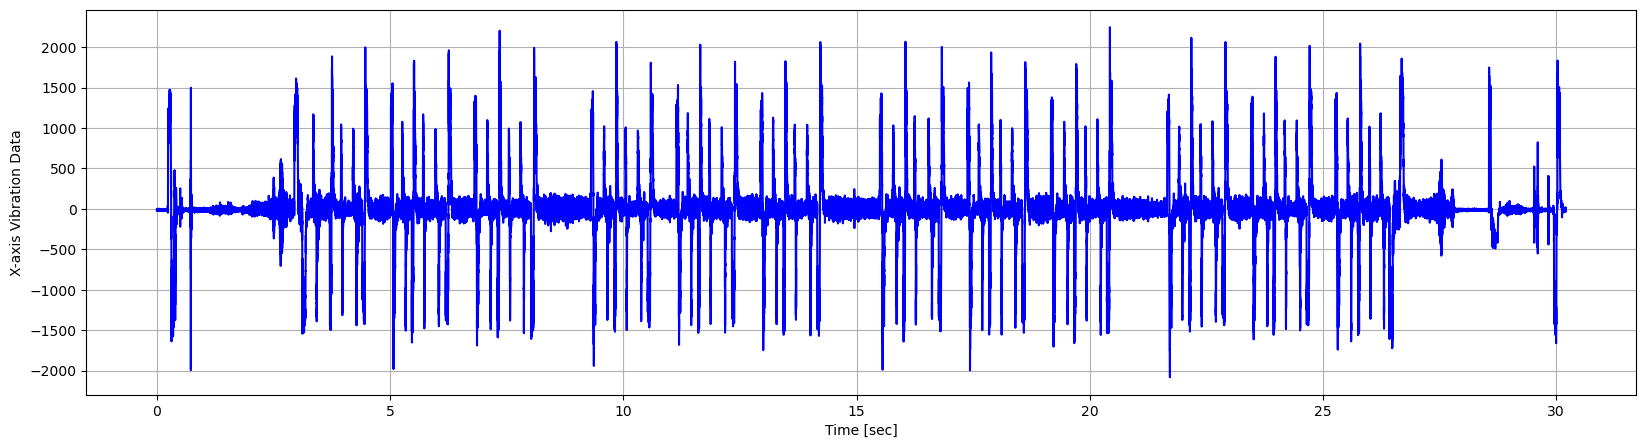

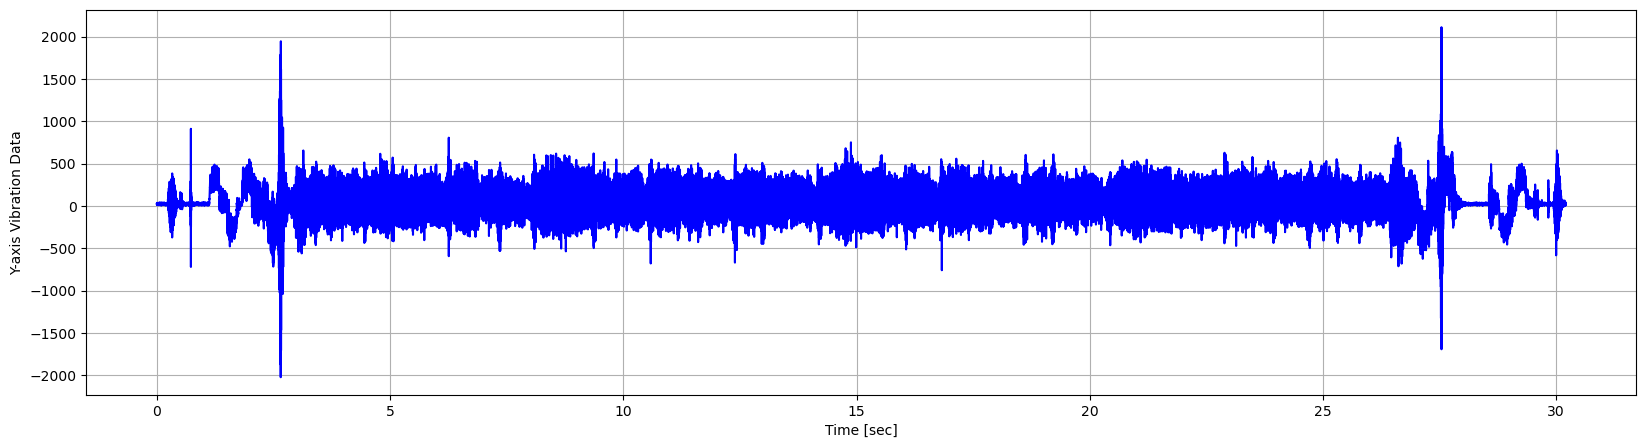

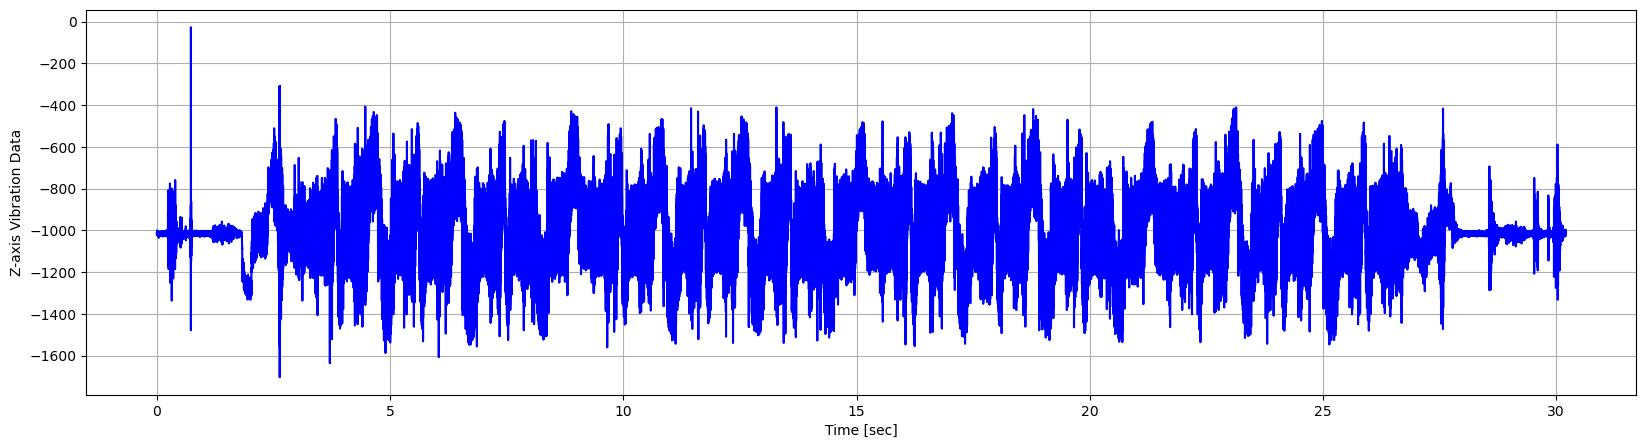

In [18]:
#Signal response of a good run for machine 1 and operation 1
file="./data/M01/OP01/good/M01_Aug_2019_OP01_000.h5"
sample = data_loader_utils.datafile_read(file)

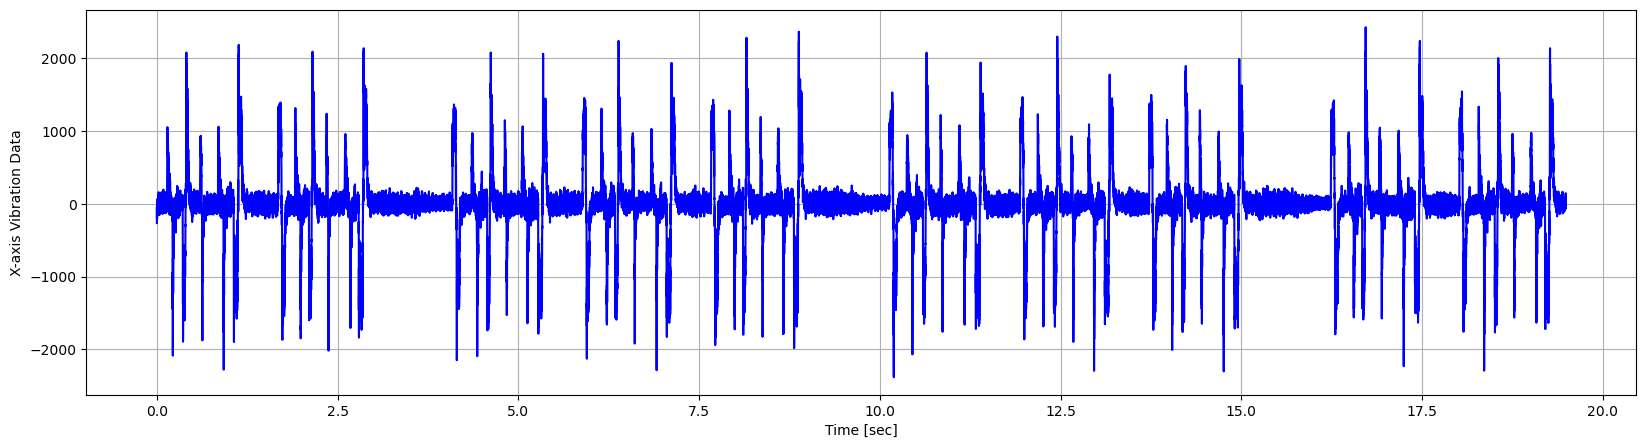

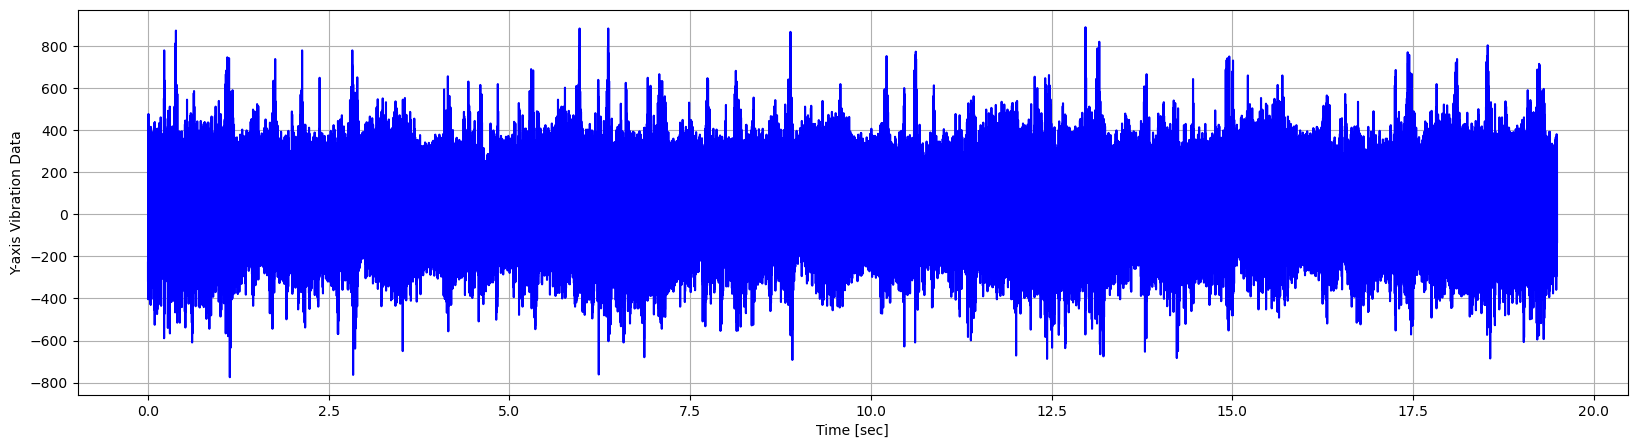

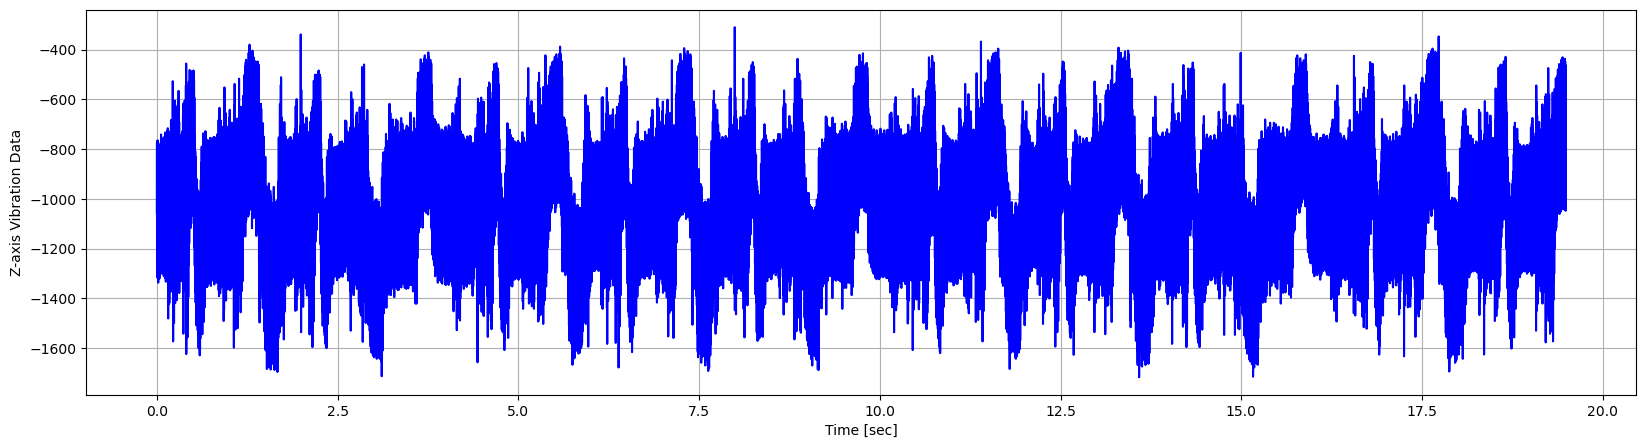

In [15]:
#singal response for bad run on machine 1 operation 1
file="./data/M01/OP01/bad/M01_Aug_2019_OP01_000.h5"
sample = data_loader_utils.datafile_read(file)

# Description of the data provided
The initial signal above show the difference between a good and bad run, however in this format it is difficult to identify the differences.
In order to work with the data a fast fourier transform must be used to find descriptive metrics for the signals given.

### Data Understanding
The data can be visualized as shown above.
In a standard cnc machining operation two sections of the vibrational response are typically different from the rest (the start and end due to spindle getting up to speed and slowing down) these sections may potentially show some of the insight into the operations with errors as certain cases such as misbalanced masses could go through a momentary resonance spike.

In order to get a more clear picture of the operation the author of the data recomends a window size of 4096 samples from empirically derived approximation, this meaning that 4096 samples in a frequency response may be adequate to get a clear picture of the operational frequany response.Further using a value lower or more than this will pad the output with zeroes using the FFT function giving incorrect results for the frequency outputs of the fourier transform and would require usage of discrete fourier transform which is more computationally expensive. (use power of two rule when choosing window size for fft).

The following section contains code that derives a few frequency response descriptive features as derived from the fft approach. The features may then be used in further modelling efforts.


In [19]:
#section of code to determine the signal descriptive metrics to be used as features
results = pd.DataFrame()
features = pd.DataFrame()

# Using TQDM to display a progress bar for this section due to the long computational time
for run in tqdm(X_data, desc="Processing", unit="run"):
    data_with_commas = [[str(value).replace('.', '') for value in sublist] for sublist in run]
    
    #set value of the X_dataframe
    X_df = pd.DataFrame(data_with_commas, columns=['x', 'y', 'z'])
    
    #set window size for the vibration analysis
    X_df = X_df.loc[0:4095] #using only 4096 elements as described previously
    
    #ensure the values are as type float and not string or object
    X_df['x'] = X_df['x'].astype(float)
    X_df['y'] = X_df['y'].astype(float)
    X_df['z'] = X_df['z'].astype(float)
    
    #create numpy array from data frame to be used in fft
    fft_data = X_df.to_numpy()
    
    #run fft on the data
    fft = np.fft.fft(fft_data,axis=0)
    
    #find the features of the data
    #calculate spectral centroid, spectral flux, peak frequency, and bandwidth for each channel
    channel_spectral_centroids = []
    channel_spectral_fluxes = []
    channel_peak_frequencies = []
    channel_bandwidths = []
    
    for channel in range(3):
        
        #finding magnitude for the channel
        magnitude = np.abs(fft)[:, channel]

        #spectral centroid calculation
        spectral_centroid = np.sum(np.fft.fftfreq(len(fft)) * magnitude) / np.sum(magnitude)
        channel_spectral_centroids.append(spectral_centroid)

        #finding spectral flux
        spectral_flux = np.sum(np.diff(magnitude) ** 2)
        channel_spectral_fluxes.append(spectral_flux)

        #finding peak frequency
        peak_frequency = np.fft.fftfreq(len(fft))[np.argmax(magnitude)]
        channel_peak_frequencies.append(peak_frequency)

        #determine bandwidth
        power_threshold = 0.5 #set the value for power threshold of bandwidth
        power = magnitude ** 2
        total_power = np.sum(power)
        threshold_power = total_power * power_threshold
        cumulative_power = np.cumsum(power[::-1])
        threshold_index = np.argmax(cumulative_power > threshold_power)
        bandwidth = np.fft.fftfreq(len(fft))[::-1][threshold_index]
        channel_bandwidths.append(bandwidth)

    #concatenate features into separate columns
    
    #creating data frame of the results for the features for XYZ
    channel_spectral_centroids = pd.DataFrame(channel_spectral_centroids)
    channel_spectral_fluxes = pd.DataFrame(channel_spectral_fluxes)
    channel_peak_frequencies = pd.DataFrame(channel_peak_frequencies)
    channel_bandwidths = pd.DataFrame(channel_bandwidths)
    
    #X channel features
    results['spectral_centroid_x'] = channel_spectral_centroids.iloc[0]
    results['spectral_flux_x'] = channel_spectral_fluxes.iloc[0]
    results['peak_frequency_x'] = channel_peak_frequencies.iloc[0]
    results['bandwidth_x'] = channel_bandwidths.iloc[0]

    #y channel features
    results['spectral_centroid_y'] = channel_spectral_centroids.iloc[1]
    results['spectral_flux_y'] = channel_spectral_fluxes.iloc[1]
    results['peak_frequency_y'] = channel_peak_frequencies.iloc[1]
    results['bandwidth_y'] = channel_bandwidths.iloc[1]

    #z channel features
    results['spectral_centroid_z'] = channel_spectral_centroids.iloc[2]
    results['spectral_flux_z'] = channel_spectral_fluxes.iloc[2]
    results['peak_frequency_z'] = channel_peak_frequencies.iloc[2]
    results['bandwidth_z'] = channel_bandwidths.iloc[2]
    
    #print(results)
    features = pd.concat([features,results])

Processing: 100%|█████████████████████████████████████████████████████████████████| 1702/1702 [14:21<00:00,  1.98run/s]


# Results
The results of the previous section are shown by the data frame displayed as follows.

In [22]:
#print the features produced using the standard fft approach
print(features.info())
#print the unscaled features results for the first five rows
print(features.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1702 entries, 0 to 0
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   spectral_centroid_x  1702 non-null   float64
 1   spectral_flux_x      1702 non-null   float64
 2   peak_frequency_x     1702 non-null   float64
 3   bandwidth_x          1702 non-null   float64
 4   spectral_centroid_y  1702 non-null   float64
 5   spectral_flux_y      1702 non-null   float64
 6   peak_frequency_y     1702 non-null   float64
 7   bandwidth_y          1702 non-null   float64
 8   spectral_centroid_z  1702 non-null   float64
 9   spectral_flux_z      1702 non-null   float64
 10  peak_frequency_z     1702 non-null   float64
 11  bandwidth_z          1702 non-null   float64
dtypes: float64(12)
memory usage: 172.9 KB
None
   spectral_centroid_x  spectral_flux_x  peak_frequency_x  bandwidth_x  \
0            -0.000063     2.639420e+12          0.002441     0.498291   


#### Modifying the y_data
The Y data is initially placed in a string object and must be changed to a data frame object.
Further changing the row values from class 'object' to string aids in downstream changes.

In [23]:
y_data = pd.DataFrame(y_data)
y_data.columns = ['class']
y_data['class'] = y_data['class'].astype(str)
print(y_data.info())
print(y_data.head())

#creating a data frame with both the features and class to be able to filter 
# the results by machine or process
features = features.reset_index()
full_df = pd.concat([features,y_data],axis=1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1702 entries, 0 to 1701
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   1702 non-null   object
dtypes: object(1)
memory usage: 13.4+ KB
None
                        class
0  M01_Aug_2019_OP00_000_good
1  M01_Aug_2019_OP00_001_good
2  M01_Aug_2019_OP00_003_good
3  M01_Aug_2019_OP00_004_good
4  M01_Aug_2019_OP00_005_good


# Addition of categorical features
The current data does not include categorical features such as the machine used or the operation. The following section add two more columns to the data frame to be used in one hot encoding.

In [24]:
#creating two new features for machine and operation
full_df['machine'] = full_df['class'].str[:3]
full_df['operation'] = full_df['class'].str[13:17]

### Filtering the data by machine and process.
The following section allows the user to specify the machine and operation that is to be used in the modelling efforts. This allows for specific groups of models and processes to be analyszed at one time.

In [25]:
#creating a function that filters the data by machine and process
#function returns the results to be used later for modelleing.
def filter_(data, MO_list, OP_list):
    
    #filter the data to only include the machine and operation specified
    filtered_data = data[data['class'].str.contains('|'.join(MO_list)) & data['class'].str.contains('|'.join(OP_list))]
    
    #create new features from the machine and operation in the 'class column'
    X_vals = filtered_data.drop('class',axis=1)
    
    # Extract only the labels "good" or "bad" from the 'class' column
    y_vals = filtered_data['class'].str.contains('good').map({True:"OK",False:"NOK"})
    y_vals = pd.DataFrame(y_vals)
    
    
        
    return X_vals, y_vals

Machines = ["M01","M02","M03"]
Operations = ["OP00","OP01","OP02","OP03","OP04","OP05","OP06","OP07","OP08","OP09","OP10","OP11","OP12","OP13","OP14"]
X_vals, y_vals = filter_(full_df,Machines,Operations)
print(X_vals.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1702 entries, 0 to 1701
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                1702 non-null   int64  
 1   spectral_centroid_x  1702 non-null   float64
 2   spectral_flux_x      1702 non-null   float64
 3   peak_frequency_x     1702 non-null   float64
 4   bandwidth_x          1702 non-null   float64
 5   spectral_centroid_y  1702 non-null   float64
 6   spectral_flux_y      1702 non-null   float64
 7   peak_frequency_y     1702 non-null   float64
 8   bandwidth_y          1702 non-null   float64
 9   spectral_centroid_z  1702 non-null   float64
 10  spectral_flux_z      1702 non-null   float64
 11  peak_frequency_z     1702 non-null   float64
 12  bandwidth_z          1702 non-null   float64
 13  machine              1702 non-null   object 
 14  operation            1702 non-null   object 
dtypes: float64(12), int64(1), object(2)
me

# Class imbalance
Due to the nature of industrial cnc machining operations, the ratio of successful to unsuccessful is extremely large and will require minority class over sampling.

In [26]:
y_vals.describe() #display the class imbalance between positive and negative outcomes for this process.

,class
count,1702
unique,2
top,OK
freq,1632


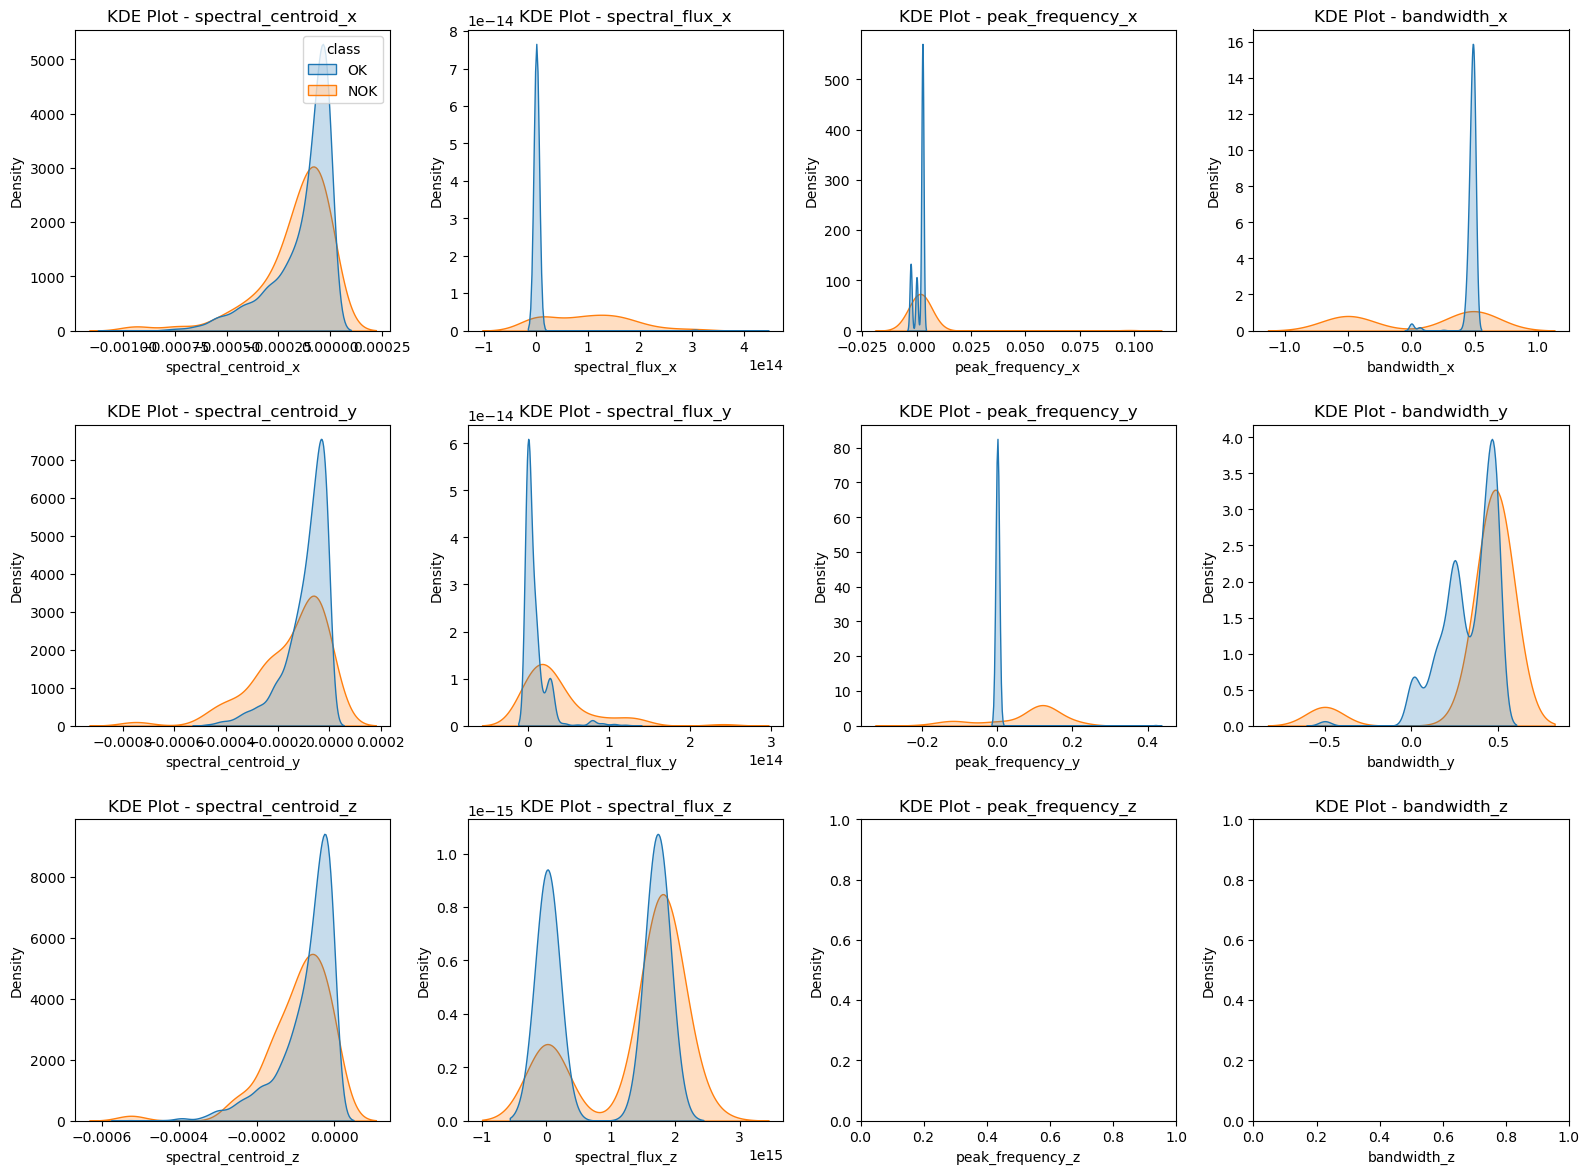

In [43]:
warnings.filterwarnings("ignore") #some values may be zero and will give warning when plotting
# Displaying KDE plots for the differences between positive and negative outcomes.

columns = X_vals.columns[1:13]
num_rows = len(columns)//4

fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(16, 4 * num_rows))
axes = axes.flatten()

#creating plots for each row showing KDE
k = 0
for i, column in enumerate(columns):
    if k == 0:
        sns.kdeplot(x=X_vals[column], hue=y_vals['class'], ax=axes[i], fill=True, common_norm=False)
        axes[i].set_title(f'KDE Plot - {column}')
    else:
        sns.kdeplot(x=X_vals[column], hue=y_vals['class'], ax=axes[i], fill=True, common_norm=False,legend = False)
        axes[i].set_title(f'KDE Plot - {column}')
    k += 1

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


# Further Data Description
The Z valus frequencies and bandwidths are not computed since all values are negative. This can be modified using fftshift, however this may be unnecessary for this project.

# Modelling
This section of the notebook adresses the modelling effort for the crisp dm framework and the selected model is shown.
 ### Model Generation
The initial model generation in this case is to verify that the features used will work adequately. In this case the standard fft approach has given me an accuracy score of %99.7 for the test data which is close to the desired outcome but not always repeatable due to the random nature of the model used (random forest).

In [44]:
#setting the "ok" class to 0 and 'NOK' to 1 allows for more simple scoring metrics to be used in the gridesarch 
map_labels = {'OK':0,'NOK':1}
y_vals_numeric = y_vals['class'].map(map_labels)

#split the test and training data before applying pre-processing
X_train, X_test, y_train, y_test = train_test_split(X_vals, y_vals_numeric, test_size=0.3,stratify=y_vals)

#oversample the minority class
oversampler = RandomOverSampler(sampling_strategy='minority')
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

#transformer:onehot encoder and standard scaler
preprocess = ColumnTransformer(transformers=[
    ('oneHot',OneHotEncoder(),['machine','operation'])],
    remainder = StandardScaler())

forest_pipe = Pipeline([
    ('preprocess', preprocess),
    ('forest',RandomForestClassifier())
])

n_est = range(20,40) #number of estimators for random forest grid

n_splits = range(50,60)#number of splits in the data for the random forest grid
#this value was artificially increased as the model tended to reduce this number at the expense of test accuracy
# the small range is for speed of model fitting.

#hyper parameters for the forest gridsearch
forest_params = {
    'forest__n_estimators':n_est,
    'forest__max_depth':n_splits
}

#random forest gridsearch
grid_search = GridSearchCV(estimator=forest_pipe,
                          param_grid=forest_params,
                          cv=5,
                          scoring = 'precision') #after experimentation the precision yielded best confusion matrices.
#after much experimentation using 'recall', 'roc-auc' and others, 'precision was found to be best scoring metric used'
#fitting the gridsearch on the oversampled data sets
grid_search.fit(X_train_resampled,y_train_resampled)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('oneHot',
                                                                         OneHotEncoder(),
                                                                         ['machine',
                                                                          'operation'])])),
                                       ('forest', RandomForestClassifier())]),
             param_grid={'forest__max_depth': range(50, 60),
                         'forest__n_estimators': range(20, 40)},
             scoring='precision')

# Best model
From the gridsearch the best model pararameters are given below:


In [45]:
best_model = grid_search.best_estimator_
print(best_model)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('oneHot', OneHotEncoder(),
                                                  ['machine', 'operation'])])),
                ('forest',
                 RandomForestClassifier(max_depth=50, n_estimators=21))])


In [50]:
#finding score of the model on the training set excluding the oversampling
predictions = best_model.predict(X_test)
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test,predictions)
print("The best estimator training score is: %" , float(acc * 100))

The best estimator training score is: % 99.60861056751467


# Grid Search Results
The gird search results are shown as follows for the two hyper parameters used:


[Text(0.5, 23.52222222222222, 'Depth'),
 Text(50.722222222222214, 0.5, 'N Estimators'),
 Text(0.5, 1.0, 'Score of GridSearch')]

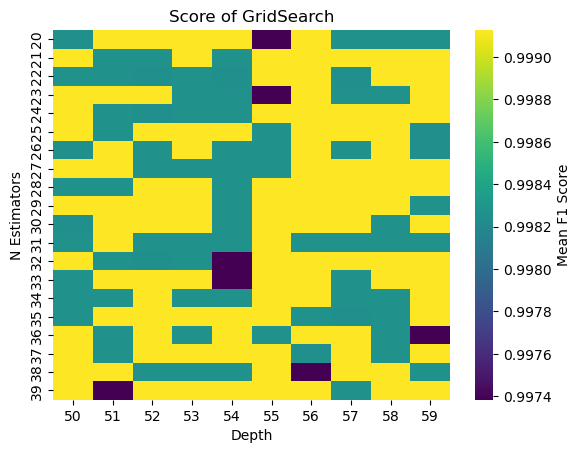

In [51]:
# Get the grid search results
cv_results = grid_search.cv_results_

# Extract relevant information
param_grid = grid_search.param_grid
mean_precision_scores = cv_results['mean_test_score'].reshape(len(param_grid['forest__n_estimators']), -1)

# Create a DataFrame for better visualization
df_results = pd.DataFrame(mean_precision_scores, index=param_grid['forest__n_estimators'], columns=param_grid['forest__max_depth'])

# Create a heatmap using Seaborn

sns.heatmap(df_results, annot=False, cmap='viridis', fmt='.4f', cbar_kws={'label': 'Mean F1 Score'}).set(xlabel='Depth',ylabel='N Estimators',title = 'Score of GridSearch')


# Evaluation
This section shows the results of evaluating the modelling efforts using the test data for the classification:

Text(0.5, 1.0, 'Test data confusion matrix')

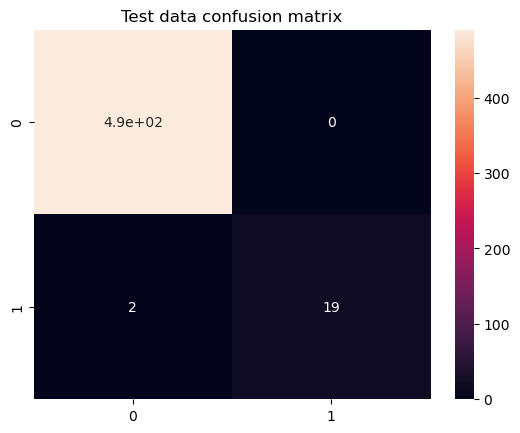

In [52]:
matrix = confusion_matrix(y_test,predictions)
sns.heatmap(matrix, annot = True).set_title("Test data confusion matrix")

1.0


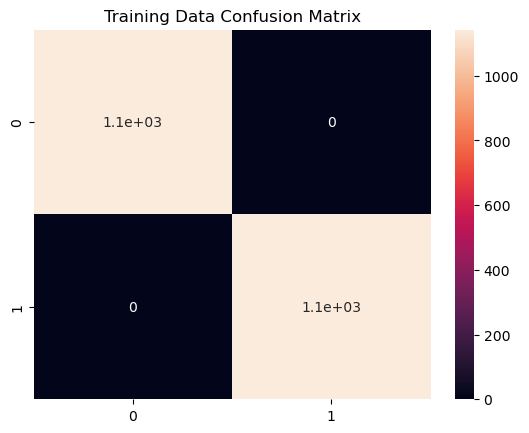

In [53]:
training_pred = best_model.predict(X_train_resampled)
acc_training = accuracy_score(y_train_resampled,training_pred)
matrix_training = confusion_matrix(y_train_resampled,training_pred)
sns.heatmap(matrix_training,annot=True).set_title('Training Data Confusion Matrix')
print(acc_training)

 The model is well withing the wanted range of accuracy. In this case the confusion matrix of the test data indicates that the model was able to determine the "NOK" outcomes 19/21 times, with only two false positive cases.

In [55]:
#determining the feature importances from the gridsearch
rf_classifier = best_model.named_steps['forest'] 
importance = rf_classifier.feature_importances_

#finding feature names after preprocesser is applied as in the pipeline
preprocessor = best_model.named_steps['preprocess']
preprocessed_features = preprocessor.transform(X_train)

#determine index of onehot in the preprocessor
one_hot_index = [i for i, (name, _, _) in enumerate(preprocessor.transformers) if name == 'oneHot'][0]

#determinng the feature names
categorical_feature_names = preprocessor.transformers_[one_hot_index][1].get_feature_names_out()

#feature names of numerical columns
numerical_names = X_train.columns[preprocessor.transformers_[one_hot_index + 1][2]]

#adding categorical and numerical feature names
feature_names = list(categorical_feature_names) + list(numerical_names)

#map feature names to importance from randomforest
feature_importance_dict = dict(zip(feature_names, importance))
feature_importance_df = pd.DataFrame(list(feature_importance_dict.items()), columns=['Feature', 'Importance'])


Text(0.5, 1.0, 'Feature Importance In Best Model')

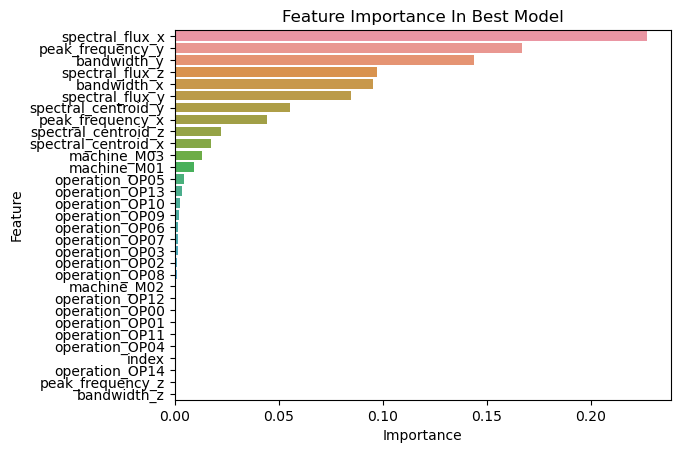

In [57]:
#plotting the feature importances in descending order for the model
sorted_importance = feature_importance_df.sort_values(by = 'Importance',ascending = False)

sns.barplot(data = sorted_importance,x='Importance',y='Feature').set_title('Feature Importance In Best Model')

# Best model
The final parameters used for the best model can be seen below:


In [58]:
best_params = grid_search.best_params_

print("The best parameters for the model are: ")

for param, val in best_params.items():
    print(f"{param}: {val}")

The best parameters for the model are: 
forest__max_depth: 50
forest__n_estimators: 21


# Deployment
 The best model can now be save from the gridsearch and refit to the training data:
 

<Axes: >

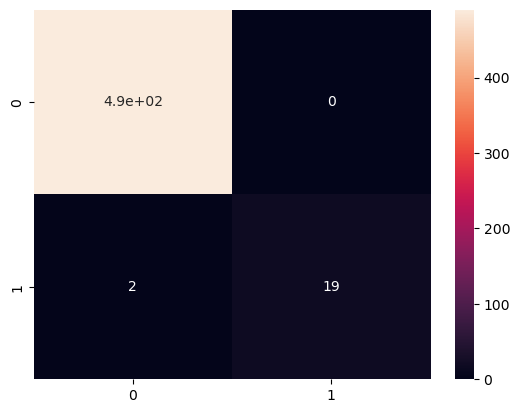

In [65]:
#Creating final model using the best parameters from the grid search
Final = RandomForestClassifier(n_estimators=best_params['forest__n_estimators'],
                              max_depth = best_params['forest__max_depth'],
                              warm_start=True)
Final.fit(preprocess.fit_transform(X_train),y_train)

Final_predictions = Final.predict(preprocess.fit_transform(X_test))
matrix = confusion_matrix(y_test,Final_predictions)
sns.heatmap(matrix, annot = True)

In [66]:
print(Final.get_params)

<bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=50, n_estimators=21, warm_start=True)>


In [67]:
#saving the best model for deployment
import joblib

final_model = Final
joblib.dump(final_model, 'final_model.joblib')

['final_model.joblib']

In [68]:
#loading saved model
loaded_model = joblib.load('final_model.joblib')
